In [1]:
import numpy as np
from scipy.stats import linregress
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
from utils_qm import save_obj, load_obj

import sklearn.model_selection as sk

import pandas as pd
import explore_qml_data as eqd
from rdkit import Chem

from matplotlib import pyplot as plt

# Energy of first coordination sphere as baseline

### Initialize database

In [2]:
# data preparation
paths = qmi.wrapper_alch_data()
exclude='/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000829/atomic_energies_with_mic.txt'
paths.remove(exclude)
paths.remove('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001265/atomic_energies_with_mic.txt')
data, molecule_sizes = qmi.load_alchemy_data(paths)

all_local_reps = qmi.generate_atomic_representations(data, molecule_sizes)

atomic_database = pd.DataFrame(index=np.arange(molecule_sizes.sum()), columns=['mol_id', 'smiles', 'Z', 'atomic energy', 'atomisation energy', 'charge NN'])
# make a database
index_database = 0
for i, p in enumerate(paths):
    data = np.loadtxt(p)
    # get smiles
    comp = p.split('/')[-2]
    xyz_path = f'/home/misa/datasets/qm9/{comp}.xyz'
    smiles = eqd.get_smiles(xyz_path)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    cnn = eqd.get_charge_neighbours(mol)
    for d, c in zip(data, cnn):
        atomic_database.at[index_database, 'mol_id'] = i
        atomic_database.at[index_database, 'smiles'] = smiles
        atomic_database.at[index_database, 'Z'] = d[0]
        atomic_database.at[index_database, 'atomic energy'] = d[5]
        atomic_database.at[index_database, 'atomisation energy'] = d[6]
        atomic_database.at[index_database, 'charge NN'] = c
        index_database += 1

In [3]:
def add_baseline(data, tr_data, baseline_model):
    """
    adds a column with the baseline to the data set, the baseline is generated from the training data
    """
    
    if baseline_model == 'none':
        data['baseline'] = len(data)*[0.0]
    
    elif baseline_model == 'mee':
        baseline_mee(data, tr_data)
    elif baseline_model == 'cnn':
        baseline_cnn(data, tr_data)
    else:
        raise Exception('Undefined baseline model')
def baseline_cnn(data, tr_data):
    """
    baseline is linear fit of atomic energy vs total nuclear charge of nn
    """
    nuc_charges = set(tr_data['Z'])
    baseline_models = dict()
    for Z in nuc_charges:
        slope, intercept = get_linear_baseline_model_cs1(tr_data, Z)
        baseline_models[Z] = (slope, intercept)

    # calculate baseline value for every atom
    data['baseline'] = len(data)*[0.0]
    for k in baseline_models.keys():
        data.loc[data['Z']==k, 'baseline'] = data.loc[data['Z']==k, 'charge NN']*baseline_models[k][0]+baseline_models[k][1]
        
def baseline_mee(data, tr_data):
    nuc_charges = set(tr_data['Z'])
    nuc_charges = list(nuc_charges)
    nuc_charges.sort()
    
    # ensure that baseline value can be created for all atoms
    nuc_charges_all = set(data['Z'])
    nuc_charges_all = list(nuc_charges_all)
    nuc_charges_all.sort()
    assert nuc_charges == nuc_charges_all, "Print not all elements in training data"
    
    # create baseline
    data['baseline'] = len(data)*[0.0]
    for n in nuc_charges:
        mean_val = tr_data.loc[tr_data['Z'] == n, 'atomic energy'].mean()
        data.loc[data['Z'] == n, 'baseline'] = mean_val
    
def get_mean_cs1(data, Z):
    """
    for element with charge Z get charge of NN and mean atomic energy at this charge
    """
    unique_nn = list(set(data.loc[(data['Z'] == Z), 'charge NN']))
    unique_nn.sort()
    mean_energy = []
    for u in unique_nn:
        mean = data.loc[(data['Z'] == Z) & (data['charge NN'] == u), 'atomic energy'].mean()
        mean_energy.append(mean)
    return(np.array([unique_nn, mean_energy]))

def get_linear_baseline_model_cs1(data, Z):
    """
    get mean atomic energy for every set of nearest neighbours and make linear fit to charge of NN vs mean atomic energy
    """
    mean_cs1 = get_mean_cs1(data, Z)
    lm = linregress(mean_cs1[0], mean_cs1[1])
    return(lm[0], lm[1])

def split_molecule_indices(num_data_pts, tr_size):
    molecule_indices = np.arange(num_data_pts)
    tr_indices_mol, test_indices_mol, dummy1, dummy2 = sk.train_test_split(molecule_indices,molecule_indices,train_size=tr_size)
    return(tr_indices_mol, test_indices_mol)

def train_test_cycle(baseline_model, data, lam, reps, sigma, tr_size):
    # split data in training and test
    num_mols = len(set(data['mol_id']))
    tr_indices_mol, test_indices_mol = split_molecule_indices(num_mols, tr_size)
    
    tr_data = data[data['mol_id'].isin(tr_indices_mol)]
    reps_tr = reps[tr_data.index]   
    test_data = data[data['mol_id'].isin(test_indices_mol)]
    reps_test = reps[test_data.index]

    # add baseline to dataset
    add_baseline(data, tr_data, baseline_model)


    # calculate delta
    data['delta'] = data['atomic energy'] - data['baseline']
    delta_tr = data.loc[data.index.isin(tr_data.index), 'delta']

    coeffs = qmi.train_kernel(reps_tr, delta_tr, sigma, lam)
    delta_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
    baseline_test =  data.loc[data.index.isin(test_data.index), 'baseline']

    labels_predicted = delta_predicted + baseline_test
    labels_test = data.loc[data.index.isin(test_data.index), 'atomic energy']


    #print(labels_predicted)
    mae = (np.abs(labels_predicted - labels_test)).mean()
    return(mae)

def crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv):
    mae = []
    for n in range(num_cv):
        mae.append(train_test_cycle(baseline_model, data, lam, reps, sigma, tr_size))
    mae = np.array(mae)
    return(mae.mean(), mae.std())

In [14]:
tr_size = 100
data = atomic_database.copy()

num_mols = len(set(data['mol_id']))
tr_indices_mol, test_indices_mol = split_molecule_indices(num_mols, tr_size)

tr_data = data[data['mol_id'].isin(tr_indices_mol)]

u, e = get_mean_cs1(tr_data, 6)

In [17]:
m,b = get_linear_baseline_model_cs1(tr_data, 6)

Text(0, 0.5, '$E_I$ (kcal/mol)')

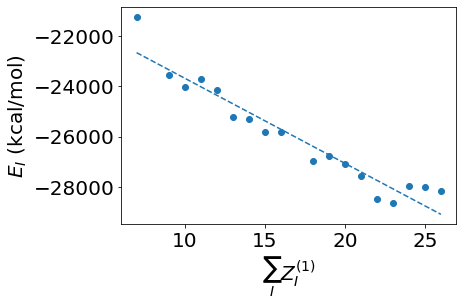

In [19]:
plt.rcParams['font.size'] = 20
x = np.linspace(np.amin(u), np.amax(u), 100)
plt.plot(u,e*627, 'o')
plt.plot(x, 627*(x*m+b), '--', color='tab:blue')
plt.xlabel(r'$\sum_I Z_I^{(1)}$')
plt.ylabel(r'$E_I$ (kcal/mol)')

# No baseline

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'none'

sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
#set_sizes = np.concatenate((np.logspace(0, 13, 14, base=2).astype(int), np.array([12000])))
set_sizes = [900]
for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(baseline_model, data, lam_val, reps, sigma, tr_size, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
save_obj(lcurves, '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/no_baseline_coarse_grid')

In [ ]:
lcurves_sigma = {'sig_22.627416997969522': np.array([[9.00000000e+02, 2.52051450e-01, 6.33494288e-02]]),
 'sig_48.50293012833276': np.array([[9.00000000e+02, 4.86423195e-02, 3.55630091e-03]]),
 'sig_103.96830673359823': np.array([[9.00000000e+02, 1.98577554e-02, 7.99814413e-04]]),
 'sig_222.8609442038079': np.array([[9.00000000e+02, 1.97048111e-02, 3.18936804e-04]]),
 'sig_477.7128916668455': np.array([[9.00000000e+02, 2.36696070e-02, 1.83672148e-03]])}

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'none'

lambdas = [1e-1, 1e-3, 1e-5, 1e-7]
num_cv = 3

lcurves_opt = dict()

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(7, 9, 3, base=2).astype(int), np.array([900])))

for sigma_k in lcurves_sigma.keys():
    sigma = float(sigma_k.split('_')[1])

    # calculate error for every training point size
    for lam in lambdas:
        print(sigma, lam)
        error_cv = []
        error_std = []
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
            error_cv.append(err)
            error_std.append(err_std)
    
        lcurves_opt[f'sig_{sigma}_lambda_{lam}'] = np.array([set_sizes, error_cv, error_std]).T
save_obj(lcurves_opt, '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/no_baseline_lcurves_opt' )

In [ ]:
lcurves_opt = load_obj('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/no_baseline_lcurves_opt')

fig, ax = plt.subplots(1,1)
for k in lcurves_opt.keys():
    s, l = np.round(float(k.split('_')[1])), float(k.split('_')[-1])
    N = lcurves_opt[k][:,0]
    MAE = lcurves_opt[k][:,1]
    ax.plot(N, MAE, '-o', label = f'$\sigma = {s}$, $\lambda = {l}$')
ax.legend(bbox_to_anchor = (1.05, 1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_ylabel('MAE (Ha)')

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(lcurves_opt['sig_222.8609442038079_lambda_1e-05'][:,0], lcurves_opt['sig_222.8609442038079_lambda_1e-05'][:,1], '-o')
#ax.plot(lcurves_opt['sig_477.7128916668455_lambda_1e-07'][:,0], lcurves_opt['sig_477.7128916668455_lambda_1e-07'][:,1], '-o')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_ylabel('MAE (Ha)')

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'none'

lam = 1e-7
sigma = 222.8609442038079
num_cv = 10

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(1, 9, 11, base=2).astype(int), np.array([900])))

error_cv = []
error_std = []
for idx, tr_size in enumerate(set_sizes):
    err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
    error_cv.append(err)
    error_std.append(err_std)
    

In [ ]:
best_lcuvrve = np.array([set_sizes, error_cv, error_std]).T
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/best_no_baseline.txt', best_lcuvrve )

# Baseline mean atomic energy per element

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'mee'

sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
#set_sizes = np.concatenate((np.logspace(0, 13, 14, base=2).astype(int), np.array([12000])))
set_sizes = [900]
for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(baseline_model, data, lam_val, reps, sigma, tr_size, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
lcurves

In [ ]:
lcurves_sigma = {'sig_22.627416997969522': np.array([[9.00000000e+02, 9.39391919e-02, 1.21955844e-02]]),
 'sig_48.50293012833276': np.array([[9.00000000e+02, 2.97992703e-02, 3.46011400e-03]]),
 'sig_103.96830673359823': np.array([[9.00000000e+02, 2.25059742e-02, 3.10376644e-03]]),
 'sig_222.8609442038079': np.array([[9.00000000e+02, 5.30568600e-02, 1.38223282e-02]])}

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'mee'

lambdas = [1e-1, 1e-3, 1e-5, 1e-7]
num_cv = 3

lcurves_opt = dict()

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(7, 9, 3, base=2).astype(int), np.array([900])))

for sigma_k in lcurves_sigma.keys():
    sigma = float(sigma_k.split('_')[1])

    # calculate error for every training point size
    for lam in lambdas:
        print(sigma, lam)
        error_cv = []
        error_std = []
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
            error_cv.append(err)
            error_std.append(err_std)
    
        lcurves_opt[f'sig_{sigma}_lambda_{lam}'] = np.array([set_sizes, error_cv, error_std]).T
save_obj(lcurves_opt, '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/mean_energy_element/lcurves_opt' )

In [ ]:
lcurves_opt

In [ ]:
fig, ax = plt.subplots(1,1)
for k in lcurves_opt.keys():
    s, l = np.round(float(k.split('_')[1])), float(k.split('_')[-1])
    N = lcurves_opt[k][:,0]
    MAE = lcurves_opt[k][:,1]
    ax.plot(N, MAE, '-o', label = f'$\sigma = {s}$, $\lambda = {l}$')
ax.legend(bbox_to_anchor = (1.05, 1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_ylabel('MAE (Ha)')

In [ ]:
#lcurves['sig_103.96830673359823_lambda_1e-07']
plt.rcParams['font.size'] = 15
N = lcurves_opt['sig_103.96830673359823_lambda_1e-05'][:,0]
MAE = lcurves_opt['sig_103.96830673359823_lambda_1e-05'][:,1]

N = lcurves_opt['sig_222.8609442038079_lambda_1e-07'][:,0]
MAE = lcurves_opt['sig_222.8609442038079_lambda_1e-07'][:,1]


fig, ax = plt.subplots(1,1)
#ax.plot(set_sizes, np.array(error_cv)*627, '-o', label = 'new model')

ax.plot(N, MAE*627, '-o', label = '$\sigma = 23$, $\lambda = 10^{-3}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('MAE (kcal/mol)')

In [ ]:
### more cv's

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'mee'

lam = 1e-5
sigma = 103.96830673359823
num_cv = 10

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(4, 9, 6, base=2).astype(int), np.array([900])))

error_cv = []
error_std = []
for idx, tr_size in enumerate(set_sizes):
    err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
    error_cv.append(err)
    error_std.append(err_std)
    

In [ ]:
error_cv

In [ ]:
lcurve2 = np.array([set_sizes, error_cv, error_std]).copy()
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/mean_energy_element/best3.txt', lcurve2.T)

In [ ]:
plt.plot(set_sizes, error_cv, '-o')
plt.xscale('log')
plt.yscale('log')

In [ ]:
error_cv

# Baseline atomic energy as linear function of total nuclear charge of nearest neighbours

### Hyperparameter optimization

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'cnn'

sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
#set_sizes = np.concatenate((np.logspace(0, 13, 14, base=2).astype(int), np.array([12000])))
set_sizes = [900]
for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
lcurves = {'sig_0.5': np.array([[9.00000000e+02, 6.27782830e-01, 2.43970829e-02]]),
 'sig_1.0717734625362931': np.array([[9.00000000e+02, 6.42303877e-01, 6.05471595e-03]]),
 'sig_2.29739670999407': np.array([[9.00000000e+02, 6.45152778e-01, 2.29544455e-02]]),
 'sig_4.924577653379666': np.array([[9.00000000e+02, 5.52601535e-01, 2.72803974e-02]]),
 'sig_10.556063286183157': np.array([[9.00000000e+02, 3.45912824e-01, 4.16990484e-02]]),
 'sig_22.627416997969522': np.array([[9.00000000e+02, 2.52586836e-01, 2.45607081e-03]]),
 'sig_48.50293012833276': np.array([[9.00000000e+02, 3.04478830e-01, 4.14522064e-03]]),
 'sig_103.96830673359823': np.array([[9.00000000e+02, 3.39552622e-01, 2.52160219e-02]]),
 'sig_222.8609442038079': np.array([[9.00000000e+02, 3.26107723e-01, 2.22827951e-02]]),
 'sig_477.7128916668455': np.array([[9.00000000e+02, 3.89872913e-01, 1.26347927e-02]]),
 'sig_1024.0': np.array([[9.00000000e+02, 4.45090081e-01, 1.12745219e-02]])}

In [ ]:
lcurves_sigma = {'sig_10.556063286183157': np.array([[9.00000000e+02, 3.45912824e-01, 4.16990484e-02]]),
 'sig_22.627416997969522': np.array([[9.00000000e+02, 2.52586836e-01, 2.45607081e-03]]),
 'sig_48.50293012833276': np.array([[9.00000000e+02, 3.04478830e-01, 4.14522064e-03]]),
 'sig_103.96830673359823': np.array([[9.00000000e+02, 3.39552622e-01, 2.52160219e-02]]),
 'sig_222.8609442038079': np.array([[9.00000000e+02, 3.26107723e-01, 2.22827951e-02]])}

In [ ]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'cnn'

lambdas = [1e-1, 1e-3, 1e-5, 1e-7]
num_cv = 3

lcurves_opt = dict()

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(7, 9, 3, base=2).astype(int), np.array([900])))

for sigma_k in lcurves_sigma.keys():
    sigma = float(sigma_k.split('_')[1])

    # calculate error for every training point size
    for lam in lambdas:
        print(sigma, lam)
        error_cv = []
        error_std = []
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
            error_cv.append(err)
            error_std.append(err_std)
    
        lcurves_opt[f'sig_{sigma}_lambda_{lam}'] = np.array([set_sizes, error_cv, error_std]).T
save_obj(lcurves_opt, '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/nearest_neighbour/lcurves_opt' )

In [ ]:
lcurves_opt

In [8]:
lcurves = load_obj('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/nearest_neighbour/lcurves_opt')

Text(0, 0.5, 'MAE (Ha)')

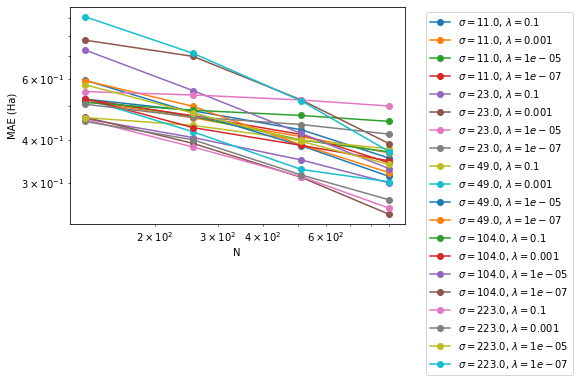

In [9]:
fig, ax = plt.subplots(1,1)
for k in lcurves:
    s, l = np.round(float(k.split('_')[1])), float(k.split('_')[-1])
    N = lcurves[k][:,0]
    MAE = lcurves[k][:,1]
    ax.plot(N, MAE, '-o', label = f'$\sigma = {s}$, $\lambda = {l}$')
ax.legend(bbox_to_anchor = (1.05, 1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_ylabel('MAE (Ha)')

In [ ]:
#lcurves['sig_103.96830673359823_lambda_1e-07']
plt.rcParams['font.size'] = 15
N = lcurves['sig_22.627416997969522_lambda_0.001'][:,0]
MAE = lcurves['sig_22.627416997969522_lambda_0.001'][:,1]

fig, ax = plt.subplots(1,1)
ax.plot(set_sizes, np.array(error_cv)*627, '-o', label = 'new model')

ax.plot(N, MAE*627, '-o', label = '$\sigma = 23$, $\lambda = 10^{-3}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('MAE (kcal/mol)')

In [4]:
data = atomic_database.copy()
reps = all_local_reps
baseline_model = 'cnn'

lam = 1e-3
sigma = 22.627416997969522
num_cv = 10

lcurves_opt = dict()

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(4, 9, 6, base=2).astype(int), np.array([900])))

error_cv = []
error_std = []
for idx, tr_size in enumerate(set_sizes):
    err, err_std = crossvalidate(baseline_model, data, lam, reps, sigma, tr_size, num_cv)
    error_cv.append(err)
    error_std.append(err_std)
    

In [6]:
lcurve = np.array([set_sizes, error_cv, error_std]).copy()
lcurve

array([[1.60000000e+01, 3.20000000e+01, 6.40000000e+01, 1.28000000e+02,
        2.56000000e+02, 5.12000000e+02, 9.00000000e+02],
       [6.13671205e-01, 5.71026221e-01, 5.24133036e-01, 4.66110817e-01,
        3.89824527e-01, 3.08413002e-01, 2.45915157e-01],
       [3.02689409e-02, 2.08533740e-02, 1.19955240e-02, 1.07741817e-02,
        4.98642117e-03, 5.39630240e-03, 1.09196943e-02]])

In [7]:
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/delta_learning/nearest_neighbour/best2.txt', lcurve.T)

# Atomisation energy of whole molecule as $\Delta$ 

In [20]:
def crossvalidate(atomic_labels, charges, data, labels, lam, molecule_sizes, reps, sigma, tr_size, num_cv):
    error = []
    for cv in range(num_cv):
        error.append(train_test_cycle(atomic_labels, charges, data, labels, lam, molecule_sizes, reps, sigma, tr_size))
    error = np.array(error)
    return(error.mean(), error.std())

def get_mean_labels(tr_indices_mol, labels, molecule_sizes, charges):
    # get atom indices from molecule indices
    tr_indices_atom = qmi.get_local_idx(tr_indices_mol, molecule_sizes)
    # split atomic indices by charge
    tr_indices_by_charge = sort_indices_by_element(tr_indices_atom, charges)
    # get mean label value split up by element
    mean_labels = dict()
    for k in tr_indices_by_charge.keys():
        mean_labels[k] = (labels[tr_indices_by_charge[k]]).mean()
    return(mean_labels)

def energy_cs0(mol, mean_labels):
    """
    multiply mean value of atomic energy for certain element with number of atoms of this element type and sum everything up
    """
    energy_estimate = 0
    nuclear_charges = mol[:,0]
    for z in np.unique(nuclear_charges):
        # number of atoms of each element
        num_nucs = np.count_nonzero(nuclear_charges == z)
        energy_estimate += mean_labels[z]*num_nucs
    return(energy_estimate)

def get_baseline(data, mol_indices, mean_labels):
    """
    calculate baseline energy
    """
    energy_baseline = []
    for m in mol_indices:
        # coordination sphere 0; count nuclear charges
        energy_baseline.append(energy_cs0(data[m], mean_labels))
    return(np.array(energy_baseline))

def sort_indices_by_element(indices, charges):
    """
    list of charges; charges[i] is the charge of the atom with index i
    """
    unique_charges = list(set(charges))
    unique_charges.sort()
    indices_by_charge = {k: [] for k in unique_charges}

    for index in indices:
        ch = charges[index]
        indices_by_charge[ch].append(index)
    return(indices_by_charge)

def split_molecule_indices(num_data_pts, tr_size):
    molecule_indices = np.arange(num_data_pts)
    tr_indices_mol, test_indices_mol, dummy1, dummy2 = sk.train_test_split(molecule_indices,molecule_indices,train_size=tr_size)
    return(tr_indices_mol, test_indices_mol)

def train_test_cycle(atomic_labels, charges, data, labels, lam, molecule_sizes, reps, sigma, tr_size):
    # split data in training and test
    data_size = len(molecule_sizes)
    tr_indices_mol, test_indices_mol = split_molecule_indices(data_size, tr_size)
    reps_tr = reps[tr_indices_mol]
    reps_test = reps[test_indices_mol]
    labels_tr = labels[tr_indices_mol]
    labels_test = labels[test_indices_mol]

    # prepare baseline
    mean_labels = get_mean_labels(tr_indices_mol, atomic_labels, molecule_sizes, charges)
    baseline_tr = get_baseline(data, tr_indices_mol, mean_labels)
    baseline_test = get_baseline(data, test_indices_mol, mean_labels)

    # train
    delta_tr = labels_tr-baseline_tr
    coeffs = qmi.train_kernel(reps_tr, delta_tr, sigma, lam)
    # predict
    delta_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
    labels_predicted = delta_predicted + baseline_test
    #print(labels_predicted)
    mae = (np.abs(labels_predicted - labels_test)).mean()
    return(mae)

In [21]:
# data preparation
# data preparation
paths = qmi.wrapper_alch_data()
exclude='/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000829/atomic_energies_with_mic.txt'
paths.remove(exclude)
data, molecule_sizes = qmi.load_alchemy_data(paths)
global_reps = qmi.wrapper_global_representations(data, molecule_sizes) # all global representations

global_labels = np.zeros(len(global_reps)) # all global labels
for idx, mol in enumerate(data):
    global_labels[idx] = data[idx][:,6].sum()
    
charges = qmi.generate_label_vector(data, molecule_sizes.sum(), value='charge')
atomic_labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='atomisation')

### Optimize sigma

In [ ]:
sigmas = np.logspace(3, 16, 13, base=2)
lam_val = 1e-7
num_cv = 10

# define number of training points for which MAE is calculated
#set_sizes = np.logspace(4, 9, 10, base=2).astype(int)
#set_sizes = np.concatenate((set_sizes, np.array([900])))
tr_size = np.array([900])

error_sigma = []
# calculate error for every training point size
for s in sigmas:
    err, err_std = crossvalidate(atomic_labels, charges, data, global_labels, lam_val, molecule_sizes, global_reps, s, tr_size, num_cv)
    #print(s, err)
    error_sigma.append([s, err, err_std])
    
error_sigma = np.array(error_sigma)

In [ ]:
error_sigma

### Learning curve

In [22]:
opt_sigma = 1.53426645e+03
lam_val = 1e-5
num_cv = 10

# define number of training points for which MAE is calculated
set_sizes = np.logspace(4, 9, 10, base=2).astype(int)
set_sizes = np.concatenate((set_sizes, np.array([900])))

error_cv = []
error_std = []
# calculate error for every training point size
for idx, tr_size in enumerate(set_sizes):
    err, err_std = crossvalidate(atomic_labels, charges, data, global_labels, lam_val, molecule_sizes, global_reps, opt_sigma, tr_size, num_cv)
    error_cv.append(err)
    error_std.append(err_std)
    
lcurve = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
lcurve

In [23]:
from matplotlib import pyplot as plt

In [24]:
mol_ae_global = np.loadtxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/learning_curve_global_label.txt')
at_ae_per_mol = np.loadtxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/opt_sigma_all_atomic_atomisation_per_molecule.txt')

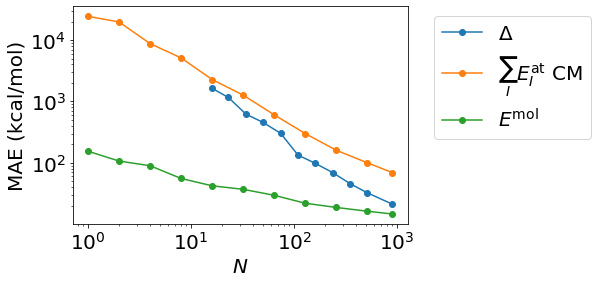

In [25]:
plt.rcParams['font.size']=20
fig,ax = plt.subplots(1,1)
ax.plot(lcurve[:,0], lcurve[:,1]*627, '-o', label = r'$\Delta$')

ax.plot(at_ae_per_mol[:,0], at_ae_per_mol[:,1]*627.5, '-o', label = r'$\sum_I E_I^{\rm at}$ CM')
ax.plot(mol_ae_global[:,0], mol_ae_global[:,1]*627.5, '-o',label = r'$E^{\rm mol} $')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel('MAE (kcal/mol)')
ax.legend(bbox_to_anchor=(1.05, 1))